## Splint5 決定木 スクラッチ

In [282]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', 250)
np.set_printoptions(threshold=np.inf)

In [283]:
from sklearn.datasets import load_iris
iris_dataset = load_iris()
X = pd.DataFrame(iris_dataset["data"], columns = iris_dataset["feature_names"])
y = pd.DataFrame(iris_dataset["target"], columns =['target'])
df = pd.concat([X,y],axis=1)
df = df.iloc[0:100,[0,4]]

df = df.sample(frac=1, random_state=1)
df_test = df.iloc[80:100,:]
df = df.iloc[0:80,:]

## 【問題１】 不純度を求める関数

In [5]:
example1 = np.ones(30,dtype="int8")
example1[0:15] = 0
example1

example2 = np.zeros(45,dtype="int8")
example2[0:15] = 6
example2[30:45] = 13
example1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

In [6]:
### 入力が2種類のラベル限定　###

def gini_function(node_t):
    class1 = np.count_nonzero(node_t ==0 )
    class2 = np.count_nonzero(node_t ==1 )
    gini = 1 - (class1/len(node_t))**2 - (class2/len(node_t))**2
    return gini    
gini_function(example1)

0.5

In [16]:
### 入力が２以上のラベル　###

def gini_function(node_t):
    #　nodeのユニーク要素を導出
    unique_class = np.unique(node_t)
    # nodeのサンプル数
    sample_num = len(node_t)

    #　node内の各クラス合計計算用、確率計算用のnp定義
    class_uni = np.array(range(len(unique_class)))
    class_pro = np.array(range(len(unique_class)),dtype="float")
    count= 0
    for i in unique_class:
        class_uni[count]= np.sum(node_t==i)
        class_pro[count]=(class_uni[count]/sample_num)**2
        count = count + 1
    
    gini = 1 - np.sum(class_pro)
        
    return   gini,sample_num,

gini_function(example2)


(0.6666666666666667, 45)

## 【問題２】情報利得を求める関数

次に、ノード間の 情報利得 を計算する関数を作成してください。問題1で作成したジニ不純度 I(t) を計算する関数を呼び出して使います。情報利得IG
は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。  
ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。  
IG(p)=I(p)−Nleft,allNp,allI(left)−Nright,allNp,allI(right) 　  
　  
p: 親ノードを示すインデックス  
left: 左側のノードを示すインデックス  
right: 右側のノードを示すインデックス
　  
＜メモ＞  
（情報利得）　＝　（親ノードのジニ係数）－（左側要素数／全要素数）＊（左側ノードのジニ係数）　  
　　　　　　　　　　　　　　　　　　　　－（右側要素数／全要素数）＊（右側ノードのジニ係数）

In [17]:
# iris データのラベル0と1('setosa', 'versicolor')、特徴量1（sepal_length）を使用。

from sklearn.datasets import load_iris
iris_dataset = load_iris()
X = pd.DataFrame(iris_dataset["data"], columns = iris_dataset["feature_names"])
y = pd.DataFrame(iris_dataset["target"], columns =['target'])
df = pd.concat([X,y],axis=1)
df = df.iloc[0:100,[0,4]]
#node_t = df
# df[df.iloc[:,0]>6.8]
# df.iloc[:,0]= (df.iloc[:,0] - min(df.iloc[:,0]))/(max(df.iloc[:,0]) - min(df.iloc[:,0]))
# #df.iloc[:,0]
# len(df[df.iloc[:,0] >0.5].values)
#len(df.values)

In [18]:
# 入力:2種類ラベルのpdのデータフレーム（問題1では入力がnp → 問題2では入力がpd）
# 出力:ジニ係数、入力サンプル数

def gini_func(node_t):
    node_t0 = node_t.query("target==0")
    node_t1 = node_t.query("target==1")
    samp_t = len(node_t.values)
    samp_t0 = len(node_t0.values)
    samp_t1 = len(node_t1.values)
    
    gini = 1 - (samp_t0/samp_t)**2 - (samp_t1/samp_t)**2

    # if samp_t0 >= samp_t1:
    #    leaf_info = 0
    # else:
    #    leaf_info = 1
    
    return   gini, samp_t
    

In [28]:
#　0列目の特徴量を、閾値により２つに分割する（0列目は正規化処理、閾値は原則的に0.5）

def node_split(node_t, threshold=0.5):
    node_t.iloc[:,0] = (node_t.iloc[:,0] - min(node_t.iloc[:,0]))/(max(node_t.iloc[:,0]) - min(node_t.iloc[:,0]))
    node_l = node_t[node_t.iloc[:,0] < threshold ]
    node_r = node_t[node_t.iloc[:,0] >= threshold ]
    return node_l, node_r

#　情報利得を出力する関数。

def info_gain(node_t, threshold):
    node_1,node_2 = node_split(node_t,threshold)
    gini_0, samp_0 = gini_func(node_t)
    gini_1, samp_1 = gini_func(node_1)
    gini_2, samp_2 = gini_func(node_2)
    i_gain = gini_0 - samp_1/samp_0 * gini_1 - samp_2/samp_0 *gini_2
    return i_gain


In [29]:
### 検算用　diverの例に沿ったDataFrameを作成###

temp1 = np.zeros(65)
temp1 = temp1.reshape(65,1)
temp2 = np.zeros(65)
temp2 = temp2.reshape(65,1)
temp1[0:10]=1
temp1[30:60]=1
temp2[30:65]=1

temp = np.hstack([temp1,temp2])
temp_pd = pd.DataFrame(data=temp, columns=["***","target"])
info_gain(temp_pd,0.5)

0.14319526627218943

## 【問題３】学習

空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。  
ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。  
訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。  
クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。
葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。  
《組み合わせの取り方》  
全ての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。  
片側の端は今回のスクラッチはこの方法で行なってください。
他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。  
《補足》
問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度 I(p)
は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。

0.4615384615384615


Text(0, 0.5, 'info_gain')

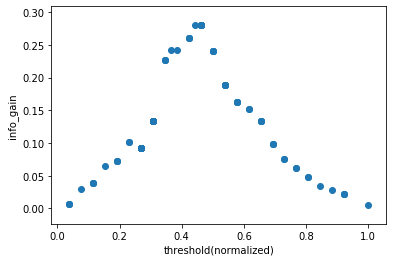

In [149]:
count = 0
# 閾値リスト
thresh_list = np.zeros(len(df))
# 閾値に対応する情報利得リスト
ig_list = np.zeros(len(df))

for i in df.iloc[:,0].values:
    try:
        ig_list[count] = info_gain(df,i)
        thresh_list[count] = i
    except ZeroDivisionError:
        i = (df.iloc[count,0] + df.iloc[count+1,0])/2
        ig_list[count] = info_gain(df,i)
        thresh_list[count] = i
    count = count + 1
        
df["info_gain"]=ig_list
df_temp = df.loc[df.info_gain == max(df.info_gain)]

#閾値の保持（iloc[0,0]・・・複数の同一閾値が取れる場合があるので一番上だけ取る）
split_rule = df_temp.iloc[0,0]
print(split_rule)
#グラフ作成
plt.scatter(thresh_list,ig_list)
plt.xlabel("threshold(normalized)")
plt.ylabel("info_gain")


## 【問題4】 推定

まずはpredict関数を作成。
predictには、dfの適当なトレインデータと問題3の学習で求められたsplit_rule(閾値)を代入している。

In [171]:
def predict(node_t,threshold):
    node_t.iloc[:,0] = (node_t.iloc[:,0] - min(node_t.iloc[:,0]))/(max(node_t.iloc[:,0]) - min(node_t.iloc[:,0]))
    node_l = node_t[node_t.iloc[:,0] < threshold ]
    node_r = node_t[node_t.iloc[:,0] >= threshold ]
    return node_l, node_r

node_l,node_r =predict(df.iloc[25:75,:], split_rule)
len(node_r) 

22

次に、ScratchDecesionTreeClassifierDepth1用の、ツリー構造作成用コードの作成する。  
ツリー構造は、pandasにて定義しており（columns=["node","parent","info","depth","child"]）、リーフノードが増えるごとにツリー構造の深さ（depth_max）にしたがってカラムが増大するようにした。

In [174]:
## ツリー構造を作成 ##
tree_df = pd.DataFrame(columns=["node","parent","info","depth","child"], dtype=int)
# 根ノードの設定
tree_df.loc[0,:] =[0,0,-1,0,0] 
# 葉ノードの作成。根→葉（depth_max:3）
node_count = len(tree_df)
depth_max = 3
for depth in range(depth_max):
    for number in range(2**depth):
        parent_number = (node_count-1)/2
        for i in range(2):
            tree_df.at[node_count+i,"node"] = node_count+i
            tree_df.at[node_count+i,"parent"] = parent_number
            tree_df.at[node_count+i,"info"] = -1
            tree_df.at[node_count+i,"depth"] = depth + 1
            tree_df.at[node_count+i,"child"] = 0
        node_count = len(tree_df)
#tree_df
tree_df = tree_df.astype("int8")
tree_df = tree_df.astype({'child': object})

# child カラムに記録。葉→根
for i in range(1,len(tree_df)):
    if tree_df.at[tree_df.at[i,"parent"], "child"] == 0:
        list = []
        list = tree_df.at[i,"node"]
        tree_df.at[tree_df.at[i,"parent"] , "child"] = list
    else:
        list = []
        list = tree_df.at[tree_df.at[i,"parent"],"child"]
        list = np.append(list, tree_df.at[i,"node"])
        tree_df.at[tree_df.at[i,"parent"] , "child"] = list
tree_df

,node,parent,info,depth,child
0,0,0,-1,0,"[1, 2]"
1,1,0,-1,1,"[3, 4]"
2,2,0,-1,1,"[5, 6]"
3,3,1,-1,2,"[7, 8]"
4,4,1,-1,2,"[9, 10]"
5,5,2,-1,2,"[11, 12]"
6,6,2,-1,2,"[13, 14]"
7,7,3,-1,3,0
8,8,3,-1,3,0
9,9,4,-1,3,0


以上を踏まえて、ScratchDecesionTreeClassifierDepth1を作成した。

In [187]:
class ScratchDecesionTreeClassifierDepth1():

    def __init__(self, max_depth):
        # ハイパーパラメータを属性として記録
        self.depth_max = max_depth
        
        # インスタンス変数
        self.split_rule = 0.5
        self.tree_df = pd.DataFrame()## ツリー構造を作成 ##
        # 分岐をカウントさせる　split_count

    def tree_generate(self):
        tree_df = pd.DataFrame(columns=["node","parent","info","depth","child"], dtype=int)
        tree_df.loc[0,:] =[0,-1,-1,0,0] 
        node_count = len(tree_df)

        for depth in range(self.depth_max):
            for number in range(2**depth):
                parent_number = (node_count-1)/2
                for i in range(2):
                    tree_df.at[node_count+i,"node"] = node_count+i
                    tree_df.at[node_count+i,"parent"] = parent_number
                    tree_df.at[node_count+i,"info"] = -1
                    tree_df.at[node_count+i,"depth"] = depth + 1
                    tree_df.at[node_count+i,"child"] = 0
                node_count = len(tree_df)

        tree_df = tree_df.astype("int8")
        tree_df = tree_df.astype({'child': object})

        for i in range(1,len(tree_df)):
            if tree_df.at[tree_df.at[i,"parent"], "child"] == 0:
                list = []
                list = tree_df.at[i,"node"]
                tree_df.at[tree_df.at[i,"parent"] , "child"] = list
            else:
                list = []
                list = tree_df.at[tree_df.at[i,"parent"],"child"]
                list = np.append(list, tree_df.at[i,"node"])
                tree_df.at[tree_df.at[i,"parent"] , "child"] = list
        return tree_df
    
    def split_decision(self,X):
    # 入力Ⅹの左端列に適応する閾値を判断する。左端列は正規化。
        thresh_list = np.zeros(len(X))
        ig_list = np.zeros(len(X))
        X.iloc[:,0] = (X.iloc[:,0] - min(X.iloc[:,0]))/(max(X.iloc[:,0]) - min(X.iloc[:,0]))
        count = 0
        for val in X.iloc[:,0].values :
            try:
                ig_list[count] = self.info_gain(X,val)
                thresh_list[count] = val
            except ZeroDivisionError:
                val = (X.iloc[count,0] + X.iloc[count+1,0])/2
                ig_list[count] = self.info_gain(X,val)
                thresh_list[count] = val
            count = count + 1
        
        X["info_gain"] = ig_list
        X_temp = X.loc[X.info_gain == max(X.info_gain)]
        split_rule = X_temp.iloc[0,0]
        return split_rule
    
        
    def gini_func(self,X):
        X_t0 = X.query("target==0")
        X_t1 = X.query("target==1")
        samp_t = len(X)
        samp_t0 = len(X_t0)
        samp_t1 = len(X_t1)
        
        gini = 1 - (samp_t0/samp_t)**2 - (samp_t1/samp_t)**2
        return   gini, samp_t

    def leaf_info(self, X):
        X_t0 = X.query("target==0")
        X_t1 = X.query("target==1")
        samp_t0 = len(X_t0)
        samp_t1 = len(X_t1)
        if samp_t1 > samp_t0:
            leaf = 1
        else:
            leaf = 0
        return leaf
        
    
    def node_split(self, X, threshold=0.5, parent_node = None):
        node_l = X[X.iloc[:,0] < threshold ]
        node_r = X[X.iloc[:,0] >= threshold ]
   
        return node_l, node_r

    def info_gain(self, X, threshold):
        node_1,node_2 = self.node_split(X,threshold)
        gini_0, samp_0 = self.gini_func(X)
        gini_1, samp_1 = self.gini_func(node_1)
        gini_2, samp_2 = self.gini_func(node_2)
        i_gain = gini_0 - samp_1/samp_0 * gini_1 - samp_2/samp_0 *gini_2
        return i_gain
    
    def fit(self, X):
        self.tree_df = self.tree_generate()

        p_node = 0
        self.split_rule = self.split_decision(X)
        node_l,node_r = self.node_split(X,split_rule,0)
        leaf_1 = self.leaf_info(node_l)
        leaf_2 = self.leaf_info(node_r)
        
        child_list = []
        child_list = self.tree_df.at[p_node,"child"]
        self.tree_df.at[child_list[0],"info"]  = leaf_1
        self.tree_df.at[child_list[1],"info"]  = leaf_2
        
        print("閾値:{}".format(self.split_rule))
        print(self.tree_df)

    def predict(self, X_test):

        X_test.iloc[:,0] = (X_test.iloc[:,0] - min(X_test.iloc[:,0]))/(max(X_test.iloc[:,0]) - min(X_test.iloc[:,0]))
        pred_node_l, pred_node_r = self.node_split(X_test,self.split_rule,0)
        
        # 親ノードから子ノードのindexを取得。
        p_node = 0
        child_list = []
        child_list = self.tree_df.at[p_node,"child"]

        #node_l に対する処理
        left_pred = self.tree_df.at[child_list[0],"info"]
        pred_node_l.loc[:,"predict"] = left_pred
        #node_r に対する処理
        right_pred = self.tree_df.at[child_list[1],"info"]
        pred_node_r.loc[:,"predict"] = right_pred
                
        return pred_node_l,pred_node_r

## 【問題５】　学習と推定

In [285]:
clf = ScratchDecesionTreeClassifierDepth1(1)
clf.fit(df)
print("\n")
pred_l,pred_r = clf.predict(df_test)
print(pred_l)
print("\n")
print(pred_r)

閾値:0.4615384615384615
   node  parent  info  depth   child
0     0      -1    -1      0  [1, 2]
1     1       0     0      1       0
2     2       0     1      1       0


    sepal length (cm)  target  predict
29           0.041667       0        0
28           0.250000       0        0
11           0.083333       0        0
18           0.458333       0        0
20           0.333333       0        0
25           0.166667       0        0
6            0.000000       0        0
1            0.125000       0        0
16           0.333333       0        0
64           0.416667       1        0
79           0.458333       1        0
5            0.333333       0        0
9            0.125000       0        0
12           0.083333       0        0
37           0.125000       0        0


    sepal length (cm)  target  predict
50           1.000000       1        1
71           0.625000       1        1
76           0.916667       1        1
75           0.833333       1        1
72     

根ノードにおける閾値、ツリー構造のデータフレーム、ノード１とノード２に分類されたサンプルが表示された。   
分類がうまく行かなかったサンプルが若干ある。

## sklearnによる決定木。

In [203]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train,y_train)
norml_X_train = scaler.transform(X_train)
norml_X_test = scaler.transform(X_test)

In [286]:
X = pd.DataFrame(iris_dataset["data"], columns = iris_dataset["feature_names"])
y = pd.DataFrame(iris_dataset["target"], columns =['target'])
df = pd.concat([X,y],axis=1)

df = df.iloc[0:100,:]
df = df.sample(frac=1, random_state=1)

df_test = df.iloc[80:100,:]
df = df.iloc[0:80,:]

X_train = df.iloc[:,0].values.reshape(-1,1)
y_train = df.iloc[:,4].values.reshape(-1,1)
X_test = df_test.iloc[:,0].values.reshape(-1,1)
y_test = df_test.iloc[:,4].values.reshape(-1,1)

In [287]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [288]:
clf_DT = DecisionTreeClassifier()
DTC_iris = clf_DT.fit(X_train, y_train)

print("推定結果ＤＴＣ：{}".format(DTC_iris.predict(X_test)))
estimate_DTC = DTC_iris.predict(X_test)

ac_score3 = accuracy_score(y_test, estimate_DTC)
print("正解率：{}".format(ac_score3))
pre_score3 = precision_score(y_test, estimate_DTC, average=None)
print("適合率：{}".format(pre_score3))
rcl_score3 = recall_score(y_test, estimate_DTC, average=None)
print("再現率：{}".format(rcl_score3))
fone_score3 = f1_score(y_test, estimate_DTC, average=None)
print("Ｆ値：{}".format(fone_score3))
print("混合行列：\n{}".format(confusion_matrix(y_test, estimate_DTC)))

推定結果ＤＴＣ：[0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0]
正解率：0.95
適合率：[1.    0.875]
再現率：[0.92307692 1.        ]
Ｆ値：[0.96       0.93333333]
混合行列：
[[12  1]
 [ 0  7]]


推定結果は、スクラッチの場合と概ね一致した。

## 【問題6】決定領域の可視化

### 可視化の便宜上、sklearnによる推定に２つの特徴量を用いて2軸のマップを準備する。

In [291]:
X_train = df.iloc[:,0:2].values.reshape(-1,2)
y_train = df.iloc[:,4].values.reshape(-1,1)
X_test = df_test.iloc[:,0:2].values.reshape(-1,2)
y_test = df_test.iloc[:,4].values.reshape(-1,1)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [292]:
clf_DT = DecisionTreeClassifier()
DTC_iris = clf_DT.fit(X_train, y_train)

print("推定結果ＤＴＣ：{}".format(DTC_iris.predict(X_test)))
estimate_DTC = DTC_iris.predict(X_test)

ac_score3 = accuracy_score(y_test, estimate_DTC)
print("正解率：{}".format(ac_score3))

推定結果ＤＴＣ：[0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0]
正解率：1.0


In [325]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel',
                    target_names=['versicolor', 'virginica']):
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    ###　スクラッチの決定木による閾値の加筆　###
    plt.plot([0.4615,0.4615],[-1.5,2.0], "red", linestyle='dashed')
    
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        print(i)
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


0
1


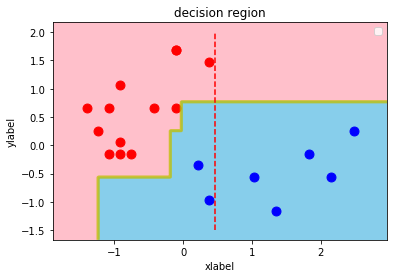

In [326]:
decision_region(X_test, estimate_DTC, DTC_iris)

In [295]:
clf.split_rule

0.4615384615384615

視覚化されたマップ上に、スクラッチによる決定領域（sulit_ruleによる閾値）を記載した。

＜試作したコードを、勉強用に残しておく＞

In [13]:
def tree_generate(root,depth):
    # root:pd、depth:int
    
    count = 0
    tree_list = []
#     while(true)
#         tree_list[count] = node(count,)
  
def node_generate(number):
    temp_list = node(number)
    if node(number).depth < max_depth and node(number)._info == -1 :
        tree_list.append(node(new1))
        tree_list.append(node(new2))
    else:
        pass
    
def node(number,parent,depth,info):
    node_number = number
    parent_node =1
    depth = 13
    _info = -1
    return [node_number,parent_node,depth,_info]
#     return depth_info,parent_node,node_number

In [41]:
for i in range(0):
    print("as")

In [8]:
class LeafNode():
    def __init__(self,number,parent,depth):
        # ハイパーパラメータを属性として記録
        # インスタンス変数
        self.node_number = number
        self.parent_node = parent
        self.leaf_info = -1
        self.depth = depth + 1
depth_max = 2
node_count = 1
for depth in range(depth_max):
    for number in range(2**depth):
        parent_number = (node_count-1)/2
        for i in range(2):
            tree_df.at[node_count+i,"node"] = node_count+i
            tree_df.at[node_count+i,"parent"] = parent_number
            tree_df.at[node_count+i,"info"] = -1
            tree_df.at[node_count+i,"depth"] = depth + 1
        node_count = len(tree_df)
tree_df

NameError: name 'tree_df' is not defined

In [144]:
def node_generate(max_depth):
    tree_df = pd.DataFrame(columns=["node","parent","info","depth","child"],dtype=int)
    root = pd.Series([0,0,0,0,0], index=tree_df.columns)

    tree_df=tree_df.append(root,ignore_index=True)
    n_count=0

    if max_depth > 0:
        for depth in range(max_depth):
            for i in range(2**depth):
                n_count = n_count+1 
                parent = (n_count+2)//2
                node_l = pd.Series([n_count,parent,-1,depth+1,0], index=tree_df.columns)
                n_count = n_count+1
                node_r = pd.Series([n_count,parent,-1,depth+1,0], index=tree_df.columns)
                tree_df = tree_df.append(node_l,ignore_index=True)
                tree_df = tree_df.append(node_r,ignore_index=True)

    return tree_df

def leaf_info(self, X):
    X_t0 = X.query("target==0")
    X_t1 = X.query("target==1")
    samp_t0 = len(X_t0)
    samp_t1 = len(X_t1)
    if samp_t1 > samp_t0:
        leaf = 1
    else:
        leaf = 0
    return leaf

In [327]:
node_generate(3)


,node,parent,info,depth,child
0,0,0,0,0,0
1,1,1,-1,1,0
2,2,1,-1,1,0
3,3,2,-1,2,0
4,4,2,-1,2,0
5,5,3,-1,2,0
6,6,3,-1,2,0
7,7,4,-1,3,0
8,8,4,-1,3,0
9,9,5,-1,3,0


In [131]:
class LeafNode():
    def __init__(self,number,parent,depth):
        # ハイパーパラメータを属性として記録
        # インスタンス変数
        self.node_number = number
        self.parent_node = parent
        self.leaf_info = -1
        self.depth = depth + 1
depth_max = 3

tree_df1 = pd.DataFrame(columns=["node","parent","info","depth","instance"])

LFN1 = LeafNode(1,0,0)
#list = list.append(LFN1)
#node_count =len(list)

tree_df1.at[0,"node"]= 0
tree_df1.at[0,"parent"] = 0
tree_df1.at[0,"info"] = -1
tree_df1.at[0,"depth"] = 0
tree_df1.at[0,"instance"] = 0
node_count = len(tree_df1)
tree_df1.at[0,"instance"] = LFN1

depth_max = 3
for depth in range(depth_max):
    for number in range(2**depth):
        parent_number = (node_count-1)/2
        for i in range(2):
            LFN = LeafNode(node_count+i , parent_number , depth+1)
            tree_df1.at[node_count+1,"instance"] = LFN
            tree_df1.at[node_count+i,"node"] = node_count+i
            tree_df1.at[node_count+i,"parent"] = parent_number
            tree_df1.at[node_count+i,"info"] = -1
            tree_df1.at[node_count+i,"depth"] = depth + 1
        node_count = len(tree_df1)
        
tree_df1 = tree_df1.astype({"node":int,"parent":int,"info":int,"depth":int,'instance': object})
tree_df1

,node,parent,info,depth,instance
0,0,0,-1,0,<__main__.LeafNode object at 0x00000261D2689508>
2,2,0,-1,1,<__main__.LeafNode object at 0x00000261D3B3AE08>
1,1,0,-1,1,NaN
4,4,1,-1,2,<__main__.LeafNode object at 0x00000261D3B3AE88>
3,3,1,-1,2,NaN
6,6,2,-1,2,<__main__.LeafNode object at 0x00000261D3B6DE08>
5,5,2,-1,2,NaN
8,8,3,-1,3,<__main__.LeafNode object at 0x00000261D3B0CAC8>
7,7,3,-1,3,NaN
10,10,4,-1,3,<__main__.LeafNode object at 0x00000261D3B3ABC8>
